In [1]:
!pip install networkx


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from spektral.data import Dataset, Graph
from spektral.layers import GraphSageConv
from spektral.utils import normalized_adjacency
from sklearn.model_selection import train_test_split
from scipy import sparse
from spektral.models.gcn import GCN 
import matplotlib.pyplot as plt
import networkx as nx
import tensorflow as tf


2023-05-17 22:10:13.993590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## FUNCTION FOR PLOTING A GRAPH

In [3]:
def plot_graph(G, communities=None):
    pos = nx.spring_layout(G, seed=42)
    
    if communities is not None:
        # Assign colors to nodes based on their communities
        colors = ['orange' if community == 0 else 'skyblue' for community in communities]
    else:
        colors = 'red'

    nx.draw(G, pos, node_color=colors, with_labels=True)
    plt.show()

## FUNCTIONS FOR GENERATING SYNTHETIC GRAPHS

### Random Graph generation

In [4]:

def generate_synthetic_graph(n_nodes, n_features, n_classes):
    #features = np.random.rand(n_nodes, n_features)
    features = np.ones((n_nodes, n_features))
    adj_matrix = np.random.randint(0, 2, size=(n_nodes, n_nodes))
    adj_matrix = np.tril(adj_matrix) + np.tril(adj_matrix, -1).T
    # Create the identity matrix and add it to the adjacency matrix
    identity_matrix = np.eye(n_nodes)
    adj_matrix = adj_matrix + identity_matrix

    adj_matrix = normalized_adjacency(adj_matrix)
    # Convert to SparseTensor
    adj_matrix = sparse.csr_matrix(adj_matrix)

    labels = np.random.randint(0, n_classes, n_nodes)
    labels = tf.keras.utils.to_categorical(labels)

    return Graph(x=features, a=adj_matrix, y=labels)



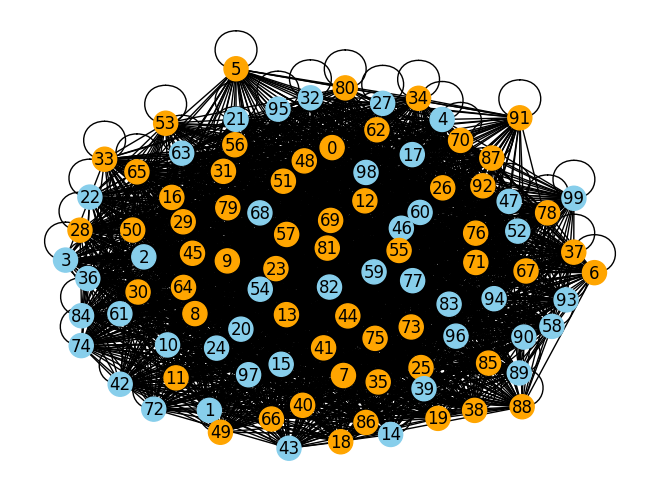

In [5]:
n_nodes = 100
n_features = 5
n_classes = 2
G = generate_synthetic_graph(n_nodes, n_features, n_classes)
nxG = nx.from_numpy_array(G.a)
labels = np.argmax(G.y,axis=1)
plot_graph(nxG,labels)

### Erdős–Rényi Generation

In [6]:

import networkx as nx

def generate_synthetic_graph_erdos(n_nodes, n_features, n_classes,prob=0.15):
    # Create features matrix with random values
    features = np.random.rand(n_nodes, n_features)
    
    # Generate a graph with a specific model (e.g., Erdős–Rényi)
    p = prob  # Probability of an edge being present between two nodes
    G = nx.erdos_renyi_graph(n_nodes, p)
    
    # Generate the adjacency matrix and make it symmetric
    adj_matrix = nx.adjacency_matrix(G)
    adj_matrix = adj_matrix + adj_matrix.T.multiply(adj_matrix.T > adj_matrix) - adj_matrix.multiply(adj_matrix.T > adj_matrix)
    
    # Create the identity matrix and add it to the adjacency matrix
    identity_matrix = np.eye(n_nodes)
    adj_matrix = adj_matrix + identity_matrix
    
    # Normalize the adjacency matrix
    adj_matrix = normalized_adjacency(adj_matrix)

    # Convert to SparseTensor
    adj_matrix = sparse.csr_matrix(adj_matrix)

    # Generate random labels and convert them to one-hot encoding
    labels = np.random.randint(0, n_classes, n_nodes)
    labels = tf.keras.utils.to_categorical(labels)

    # Return a Graph object with features, adjacency matrix, and labels
    return Graph(x=features, a=adj_matrix, y=labels)




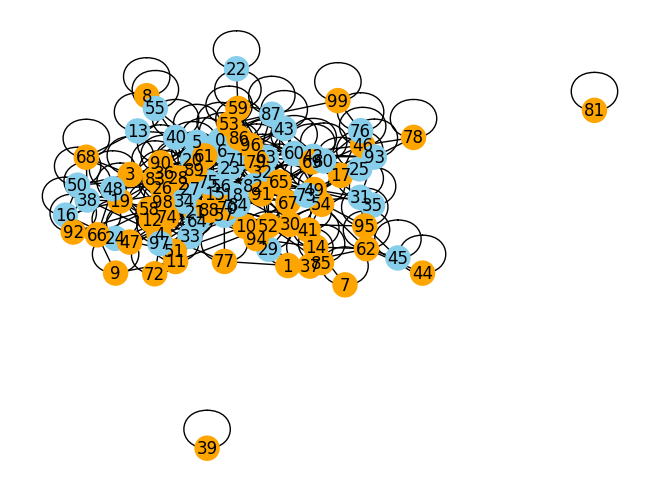

In [7]:
n_nodes = 100
n_features = 5
n_classes = 2
G = generate_synthetic_graph_erdos(n_nodes, n_features, n_classes,prob=0.05)
nxG = nx.from_numpy_array(G.a)
labels = np.argmax(G.y,axis=1)
plot_graph(nxG,labels)

### CSBM  generation

A Contextual Stochastic Block Model (CSBM) is an extension of the traditional Stochastic Block Model (SBM) that incorporates node features or covariates to better model the graph structure. The Stochastic Block Model is a generative model for graphs that assumes nodes belong to different "blocks" or "communities," and the probability of an edge between two nodes depends on the blocks to which they belong.

In a Contextual Stochastic Block Model, node features are used to inform the community membership probabilities, thereby incorporating additional context for each node. This context helps in better understanding the underlying community structure and improves the quality of the resulting partitioning.

Here's a high-level overview of how a Contextual Stochastic Block Model works:

Each node is assigned to one of K latent communities or blocks.
Node features are used to inform the probability of a node belonging to a specific community.
The probability of an edge between two nodes depends on the communities to which they belong and the edge probabilities between those communities.
The main difference between a traditional SBM and a CSBM is the incorporation of node features in the latter, which can result in more accurate community detection and better modeling of complex graph structures.

In summary, a Contextual Stochastic Block Model is a generative model for graphs that uses node features to inform the community membership probabilities, leading to a more accurate representation of the graph structure and better community detection.

In [8]:
import numpy as np
import networkx as nx
from scipy.special import softmax

def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means, feature_cov_matrix=None):
    # Assign nodes to communities
    communities = np.random.randint(0, n_communities, n_nodes)

    # Generate node features
    if feature_cov_matrix is None:
        feature_cov_matrix = np.eye(n_features)
    features = np.zeros((n_nodes, n_features))
    for k in range(n_communities):
        nodes_in_community = np.where(communities == k)[0]
        features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix, len(nodes_in_community))

    # Compute community membership probabilities based on node features
    community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

    # Generate edges based on community membership probabilities
    adjacency_matrix = np.zeros((n_nodes, n_nodes))
    for i in range(n_nodes):
        for j in range(i, n_nodes):
            if i == j:
                continue
            community_i = communities[i]
            community_j = communities[j]
            edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
            adjacency_matrix[i, j] = adjacency_matrix[j, i] = np.random.binomial(1, edge_prob)

    labels = tf.keras.utils.to_categorical(communities)
    adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
    return Graph(x=features, a=adjacency_matrix, y=labels)

    #return adjacency_matrix, features, communities


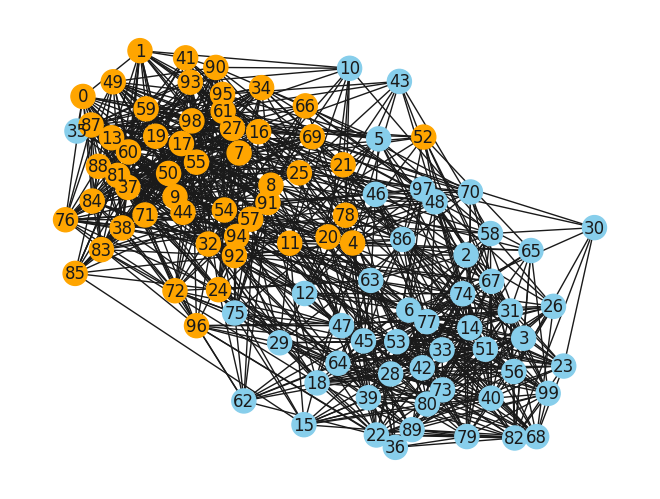

In [31]:
n_nodes = 100
n_features = 5
n_classes = 2

# Probability matrix for edges between communities
edge_prob_matrix = np.array([
    [0.8, 0.8],
    [0.6, 0.7]
])

# Node feature means for each community
node_feature_means = np.array([
    [2, 1, 0, 0, 0],
    [1, 2, 0, 0, 0]
])


G = generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, feature_cov_matrix=None)
nxG = nx.from_numpy_array(G.a)
labels = np.argmax(G.y,axis=1)
plot_graph(nxG,labels)

## Class for generating synthetic datasets

In [10]:
class SyntheticDataset(Dataset):
    def __init__(self, graphs=None, **kwargs):
        self.graphs = graphs
        super().__init__(**kwargs)

    def read(self):
        return self.graphs

## MAIN 

### Generating graphs using a particular synthetic approach

In [32]:
n_graphs = 2
n_nodes = 100
n_features = 5
n_classes = 2
# Probability matrix for edges between communities
edge_prob_matrix = np.array([
    [0.8, 0.2],
    [0.2, 0.7]
])

# Node feature means for each community
node_feature_means = np.array([
    [2, 1, 0, 0, 0],
    [1, 2, 0, 0, 0]
])

#graphs = [generate_synthetic_graph(n_nodes, n_features, n_classes) for _ in range(n_graphs)]
graphs = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, feature_cov_matrix=None) for _ in range(n_graphs)]


### Split in train and test 

In [33]:
train_graphs, test_graphs = train_test_split(graphs, test_size=0.5, random_state=42)
train_dataset = SyntheticDataset(train_graphs)
test_dataset = SyntheticDataset(test_graphs)

In [34]:
train_dataset[0]

Graph(n_nodes=100, n_node_features=5, n_edge_features=None, n_labels=2)

### Spektral Loaders

In [35]:
from spektral.data import BatchLoader,DisjointLoader,SingleLoader
batch_size = 1

# Create data loaders for training and testing data
#train_loader = BatchLoader(train_dataset, batch_size=batch_size)
#test_loader = BatchLoader(test_dataset, batch_size=batch_size)

train_loader = SingleLoader(train_dataset)
test_loader = SingleLoader(test_dataset)

### Current model

In [36]:
class GraphSageModel(Model):
    def __init__(self, n_features, n_classes, hidden_units=1024, dropout_rate=0.5):
        super().__init__()
        self.graph_sage1 = GraphSageConv(hidden_units, activation="relu", )
        self.dropout1 = Dropout(dropout_rate)
        self.graph_sage2 = GraphSageConv(n_classes, activation="softmax")
        


    def call(self, inputs, training=False):
        x, a = inputs
        x = self.graph_sage1([x, a])
        x = self.dropout1(x, training=training)
        x = self.graph_sage2([x, a])
        return x

# Instantiate the model
#model = GraphSageModel(n_features, n_classes)
model = GCN(n_labels=n_classes,channels=16,l2_reg=1.0000,dropout_rate=0)

### Compile

In [37]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

# Define early stopping to prevent overfitting
es_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=100,
    validation_data=test_loader.load(),
    validation_steps=test_loader.steps_per_epoch#,
    #callbacks=[es_callback],
)


Epoch 1/100


2023-05-17 22:13:13.395363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [100,2]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 1s 538ms/step - loss: 131.1782 - accuracy: 0.5200 - val_loss: 135.5316 - val_accuracy: 0.5200
Epoch 2/100
1/1 [==============================] - 0s 15ms/step - loss: 105.1919 - accuracy: 0.5200 - val_loss: 114.0251 - val_accuracy: 0.5200
Epoch 3/100
1/1 [==============================] - 0s 15ms/step - loss: 84.7278 - accuracy: 0.5200 - val_loss: 94.6697 - val_accuracy: 0.5200
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 71.0479 - accuracy: 0.5200 - val_loss: 77.0855 - val_accuracy: 0.5200
Epoch 5/100
1/1 [==============================] - 0s 14ms/step - loss: 57.8505 - accuracy: 0.5200 - val_loss: 61.4318 - val_accuracy: 0.5200
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 46.9141 - accuracy: 0.5200 - val_loss: 50.2263 - val_accuracy: 0.5200
Epoch 7/100
1/1 [==============================] - 0s 14ms/step - loss: 40.8496 - accuracy: 0.7500 - val_loss: 42.4069 - val_accuracy: 0.5100
Epoch 8/100
1

2023-05-17 22:13:13.860611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [100,2]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 19ms/step - loss: 34.2123 - accuracy: 0.9800 - val_loss: 34.6001 - val_accuracy: 0.5100
Epoch 9/100
1/1 [==============================] - 0s 15ms/step - loss: 26.7818 - accuracy: 0.9900 - val_loss: 26.5125 - val_accuracy: 0.5700
Epoch 10/100
1/1 [==============================] - 0s 16ms/step - loss: 18.7058 - accuracy: 0.9800 - val_loss: 18.3449 - val_accuracy: 0.8800
Epoch 11/100
1/1 [==============================] - 0s 14ms/step - loss: 10.2039 - accuracy: 0.9800 - val_loss: 10.7168 - val_accuracy: 0.9400
Epoch 12/100
1/1 [==============================] - 0s 16ms/step - loss: 7.6039 - accuracy: 0.9800 - val_loss: 9.5632 - val_accuracy: 0.9600
Epoch 13/100
1/1 [==============================] - 0s 16ms/step - loss: 7.3759 - accuracy: 0.9800 - val_loss: 11.0708 - val_accuracy: 0.9600
Epoch 14/100
1/1 [==============================] - 0s 16ms/step - loss: 7.2519 - accuracy: 0.9700 - val_loss: 12.4211 - val_accuracy: 0.9500
Epoch 15/100
1/1 

### Plot metrics

In [38]:
import pandas as pd
res=pd.DataFrame(history.history)

# Add row index as a new column
res.reset_index(inplace=True)

# Rename the new column to 'row_id'
res.rename(columns={'index': 'epoch'}, inplace=True)
res

,epoch,loss,accuracy,val_loss,val_accuracy
0,0,131.178238,0.52,135.531616,0.52
1,1,105.191887,0.52,114.025124,0.52
2,2,84.727806,0.52,94.669655,0.52
3,3,71.047890,0.52,77.085457,0.52
4,4,57.850510,0.52,61.431831,0.52
...,...,...,...,...,...
95,95,2.555676,0.99,2.630268,0.98
96,96,2.533767,0.99,2.608764,0.98
97,97,2.512192,0.99,2.587238,0.98
98,98,2.490920,0.99,2.565728,0.98


#### LOSS

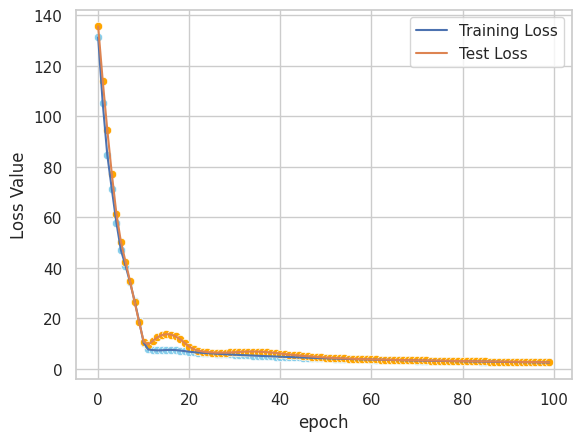

In [39]:
history.history['accuracy']

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
line1 = sns.lineplot(x="epoch", y='loss', data=res, label='Training Loss')
line2 = sns.lineplot(x="epoch", y='val_loss', data=res, label='Test Loss')


# Add points to each observation
scatter1 = sns.scatterplot(x="epoch", y='loss', data=res, marker='o', color='skyblue')
scatter2 = sns.scatterplot(x="epoch", y='val_loss', data=res, marker='o', color='orange')

# Change the y-axis label
plt.ylabel("Loss Value")

# Create a legend for the lines
plt.legend()

# Show the plot
plt.show()

#### ACCURACY

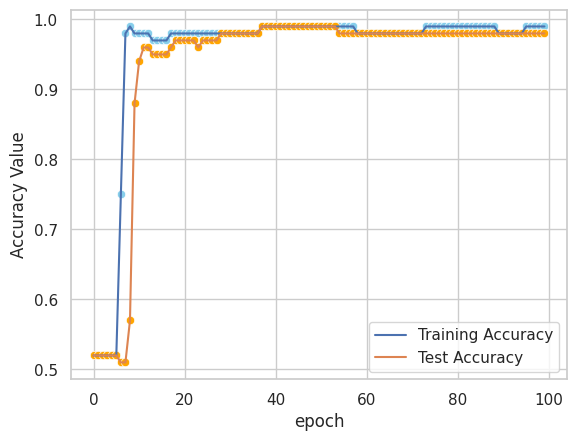

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
line1 = sns.lineplot(x="epoch", y="accuracy", data=res, label='Training Accuracy')
line2 = sns.lineplot(x="epoch", y="val_accuracy", data=res, label='Test Accuracy')

# Add points to each observation
scatter1 = sns.scatterplot(x="epoch", y="accuracy", data=res, marker='o', color='skyblue')
scatter2 = sns.scatterplot(x="epoch", y="val_accuracy", data=res, marker='o', color='orange')

# Change the y-axis label
plt.ylabel("Accuracy Value")

# Create a legend for the lines
plt.legend()

# Show the plot
plt.show()

### Calculate predictions

In [41]:
predictions = []
targets = []
step = 0
while step < test_loader.steps_per_epoch:
        step += 1
        inputs, target = test_loader.__next__()
        pred = model(inputs, training=False)
        predictions.append(pred)
        targets.append(target)
    
predictions = np.vstack(predictions)
    
targets = np.vstack(targets)
# Post-process the predictions if necessary (e.g., convert probabilities to class labels)
predicted_values = np.argmax(predictions, axis=1)
true_labels = np.argmax(targets,axis =1 )

#### Confusion matrix


In [42]:
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score
conf_mat = confusion_matrix(predicted_values, true_labels)
print(conf_mat)

[[47  1]
 [ 1 51]]


#### Metrics

In [43]:
auc_score = roc_auc_score(true_labels, predicted_values)
accuracy_score = accuracy_score(true_labels, predicted_values)

print("AUC Score:", auc_score)
print("Accuracy Score:", accuracy_score)

AUC Score: 0.9799679487179487
Accuracy Score: 0.98
